## Naive Bayes
This notebook runs the drug repurposing project's second model, Naive Bayesian. Run all 50 assays, will create balanced and unbalanced models using the sample weight in sklearn.

### Read in data

In [1]:
import random
import math

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

from sklearn import preprocessing
from sklearn.utils import compute_class_weight
from sklearn.naive_bayes import BernoulliNB

import pymc as pm
import arviz as az
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from google.colab import drive


In [2]:
drive.mount('/content/drive')

# Set working directory
path = '/content/drive/My Drive/Tox21_data/'

Mounted at /content/drive


In [3]:
xls = pd.ExcelFile(path + 'Tox21/assay_list.xls')

# Now you can list all sheets in the file
xls.sheet_names

# to read just one sheet to dataframe:
df = []
for i in range(len(xls.sheet_names)):
    df1 = xls.parse(i)
    df.append(df1)

len(df)


22

In [4]:
xls2 = pd.ExcelFile(path + 'Tox21/assay_list2.xls')

for i in range(len(xls2.sheet_names)):
    df1 = xls2.parse(i)
    df.append(df1)

len(df)



50

Run all 50 assays

In [5]:
# label_encoder object knows how to understand word labels.
from sklearn.inspection import permutation_importance

label_encoder = preprocessing.LabelEncoder()
# saving list for performance metrics
# Training
bal_accs_t = []
auc_scores_t = []
recalls_t = []
f1s_t = []
precisions_t = []

# Validation
bal_accs_v = []
auc_scores_v = []
recalls_v = []
f1s_v = []
precisions_v = []

# Testing
bal_accs_w = []
auc_scores_w = []
f1_scores = []
recall_scores = []
precision_scores = []

# Others
pos_class=[]
imp_score = []
X_tests = []
y_tests = []

# feature_top_40 = ['Chi4v', 'SMR_VSA4', 'EState_VSA5', 'SlogP_VSA10', 'EState_VSA8',
#                   'Kappa3', 'fr_Al_COO', 'SlogP_VSA8', 'PEOE_VSA10', 'fr_amide',
#                   'PEOE_VSA14', 'VSA_EState10', 'FractionCSP3', 'PEOE_VSA4',
#                   'VSA_EState9', 'VSA_EState3', 'MolLogP', 'VSA_EState7', 'BalabanJ',
#                   'fr_ketone_Topliss', 'fr_methoxy', 'MaxAbsPartialCharge',
#                   'MinAbsPartialCharge', 'FpDensityMorgan3', 'BCUT2D_MWHI',
#                   'MinAbsEStateIndex', 'fr_ester', 'fr_bicyclic', 'SlogP_VSA3',
#                   'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'fr_aniline', 'fr_para_hydroxylation',
#                   'EState_VSA2', 'VSA_EState4', 'EState_VSA9', 'PEOE_VSA9', 'SlogP_VSA1',
#                   'SlogP_VSA12', 'TPSA']

# feature_top_40 = ['FractionCSP3', 'VSA_EState3', 'SlogP_VSA10', 'PEOE_VSA14', 'fr_Al_COO',
#                   'MolLogP', 'SlogP_VSA3', 'VSA_EState9', 'VSA_EState7', 'BCUT2D_LOGPLOW',
#                   'qed', 'MinAbsEStateIndex', 'SlogP_VSA1', 'VSA_EState10',
#                   'FpDensityMorgan3', 'fr_methoxy', 'MaxAbsPartialCharge', 'BCUT2D_MWHI',
#                   'fr_ester', 'BCUT2D_MRHI', 'fr_NH1', 'fr_C_O_noCOO',
#                   'MinAbsPartialCharge', 'MinPartialCharge', 'VSA_EState5', 'TPSA',
#                   'SlogP_VSA8', 'SlogP_VSA6', 'fr_NH0', 'PEOE_VSA10', 'SlogP_VSA2',
#                   'fr_Al_OH_noTert', 'BalabanJ', 'Chi4v', 'VSA_EState1', 'VSA_EState4',
#                   'SMR_VSA4', 'fr_Ar_N', 'EState_VSA8', 'BCUT2D_CHGLO']

feature_top_40 = ['fr_C_O', 'TPSA', 'SMR_VSA1', 'NumHAcceptors', 'NumAromaticCarbocycles','NumHeteroatoms',
                  'Chi4n', 'VSA_EState10', 'VSA_EState3', 'Kappa1', 'Chi2v', 'SMR_VSA10', 'SlogP_VSA2',
                  'HallKierAlpha', 'SMR_VSA5', 'VSA_EState7', 'FractionCSP3', 'SlogP_VSA10', 'BCUT2D_LOGPLOW',
                  'VSA_EState2', 'FpDensityMorgan2', 'fr_phenol_noOrthoHbond', 'SlogP_VSA1', 'PEOE_VSA1',
                  'fr_Ar_N', 'BCUT2D_CHGLO', 'fr_ether', 'EState_VSA1', 'MinPartialCharge', 'VSA_EState6',
                  'MaxPartialCharge', 'MinAbsPartialCharge', 'VSA_EState9', 'SMR_VSA3', 'FpDensityMorgan3',
                  'SlogP_VSA12', 'fr_Al_OH_noTert', 'BalabanJ', 'MaxAbsPartialCharge', 'EState_VSA10']

for j in range(5):
  for i in range(len(df)):
      scaler = StandardScaler()

      one_assay = df[i]
      one_assay = one_assay.drop(one_assay.columns[0],axis=1).drop_duplicates(subset = 'SMILES')
      y = label_encoder.fit_transform(one_assay.iloc[:,0])
      X = one_assay[one_assay.columns.intersection(feature_top_40)]

      X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state = 42)
      X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25,
                                                            shuffle=True, random_state = j)# 5 CV on training

      near_miss = RandomUnderSampler(random_state = j)
      X_train_resampled, y_train_resampled = near_miss.fit_resample(X_train, y_train)# undersampling
      # print(Counter(y_train_resampled))
      # print(Counter(y_train))
      X_train = scaler.fit_transform(X_train_resampled)
      X_valid = scaler.transform(X_valid)
      X_test = scaler.transform(X_test)

      clf_balanced = BernoulliNB(alpha = 1).fit(X_train, y_train_resampled)

      ## model predictions
      y_train_pred = clf_balanced.predict(X_train)
      y_valid_pred = clf_balanced.predict(X_valid)
      y_test_pred = clf_balanced.predict(X_test)

      y_train_pred_prob = clf_balanced.predict_proba(X_train)[:,1]
      y_valid_pred_prob = clf_balanced.predict_proba(X_valid)[:,1]
      y_test_pred_prob = clf_balanced.predict_proba(X_test)[:,1]

      # Others
      results = permutation_importance(clf_balanced, X_train, y_train_resampled, scoring='balanced_accuracy')
      importance = results.importances_mean
      imp_score.append(importance)

      X_tests.append(X_test)
      y_tests.append(y_test)

      ## model performance metrics
      bal_acc_t = balanced_accuracy_score(y_train_resampled,y_train_pred)
      bal_acc_v = balanced_accuracy_score(y_valid, y_valid_pred)
      bal_acc_w = balanced_accuracy_score(y_test,y_test_pred)

      auc_score_t = metrics.roc_auc_score(y_train_resampled, y_train_pred_prob)
      auc_score_v = metrics.roc_auc_score(y_valid, y_valid_pred_prob)
      auc_score_w = metrics.roc_auc_score(y_test, y_test_pred_prob)

      recall_t = metrics.recall_score(y_train_resampled,y_train_pred)
      recall_v = metrics.recall_score(y_valid, y_valid_pred)
      recall_score = metrics.recall_score(y_test, y_test_pred)

      f1_t = metrics.f1_score(y_train_resampled,y_train_pred)
      f1_v = metrics.f1_score(y_valid, y_valid_pred)
      f1_score = metrics.f1_score(y_test, y_test_pred)

      precision_t = metrics.precision_score(y_train_resampled,y_train_pred)
      precision_v = metrics.precision_score(y_valid, y_valid_pred)
      precision_score = metrics.precision_score(y_test, y_test_pred)

      ## save perfomance
      ## Training
      bal_accs_t.append(bal_acc_t)
      auc_scores_t.append(auc_score_t)
      precisions_t.append(precision_t)
      recalls_t.append(recall_t)
      f1s_t.append(f1_t)

      ## Validation
      bal_accs_v.append(bal_acc_v)
      auc_scores_v.append(auc_score_v)
      precisions_v.append(precision_v)
      recalls_v.append(recall_v)
      f1s_v.append(f1_v)

      ## Testing
      bal_accs_w.append(bal_acc_w)
      auc_scores_w.append(auc_score_w)
      precision_scores.append(precision_score)
      recall_scores.append(recall_score)
      f1_scores.append(f1_score)

  print(len(bal_accs_t))
  print(j)



50
0
100
1
150
2
200
3
250
4


In [ ]:
#undersampling 80/20 split testing
print('BACC', np.mean(bal_accs_w))
print(np.std(bal_accs_w))

print('auc', np.mean(auc_scores_w))
print(np.std(auc_scores_w))

print('f1', np.mean(f1_scores))
print(np.std(f1_scores))

print('recall', np.mean(recall_scores))
print(np.std(recall_scores))

print('precision', np.mean(precision_scores))
print(np.std(precision_scores))

BACC 0.6802042207488237
0.032408884890882804
auc 0.7568247769073541
0.033291387071238084
f1 0.2936402419810377
0.09792061269107535
recall 0.6108712063153717
0.060191336581922585
precision 0.20358000764471001
0.09834947861879396


In [ ]:
#undersampling 80/20 split training
print('BACC', np.mean(bal_accs_t))
print(np.std(bal_accs_t))

print('auc', np.mean(auc_scores_t))
print(np.std(auc_scores_t))

print('f1', np.mean(f1s_t))
print(np.std(f1s_t))

print('recall', np.mean(recalls_t))
print(np.std(recalls_t))

print('precision', np.mean(precisions_t))
print(np.std(precisions_t))

BACC 0.6871640881964568
0.019982780607042595
auc 0.7658685280938576
0.023084653204472706
f1 0.6636371884031114
0.022100277936371048
recall 0.6174414991266246
0.024735094090473867
precision 0.717781664634479
0.024950552906999254


In [ ]:
#undersampling 80/20 split validation
print('BACC', np.mean(bal_accs_v))
print(np.std(bal_accs_v))

print('auc', np.mean(auc_scores_v))
print(np.std(auc_scores_v))

print('f1', np.mean(f1s_v))
print(np.std(f1s_v))

print('recall', np.mean(recalls_v))
print(np.std(recalls_v))

print('precision', np.mean(precisions_v))
print(np.std(precisions_v))

BACC 0.6804976495862681
0.029253782346981214
auc 0.7556204315024225
0.028204730447370263
f1 0.2969408304646013
0.1009585754189378
recall 0.6071029013469815
0.05876446517956377
precision 0.20686793586520108
0.09997758522854376


## Feature Importance NB

[0.00304748 0.00333584 0.0040793  0.00306769 0.00587882 0.00492349
 0.00477752 0.00394735 0.00578314 0.00746365 0.00705752 0.00494149
 0.00689846 0.00410778 0.00441511 0.00534001 0.00301549 0.00418967
 0.00374835 0.00475885 0.00358405 0.00341546 0.00313962 0.00404176
 0.00372786 0.00283961 0.00276575 0.00397693 0.00507749 0.00362368
 0.00263037 0.00360121 0.00584657 0.00358329 0.00460916 0.00194728
 0.00221876 0.00413513 0.00278051 0.00441609]
[0.00019313 0.0002114  0.00025852 0.00019441 0.00037256 0.00031201
 0.00030276 0.00025015 0.00036649 0.00047299 0.00044725 0.00031315
 0.00043717 0.00026032 0.0002798  0.00033841 0.0001911  0.00026551
 0.00023754 0.00030158 0.00022713 0.00021645 0.00019897 0.00025614
 0.00023624 0.00017995 0.00017527 0.00025203 0.00032177 0.00022964
 0.00016669 0.00022822 0.00037051 0.00022708 0.00029209 0.0001234
 0.00014061 0.00026205 0.00017621 0.00027986]


<BarContainer object of 40 artists>

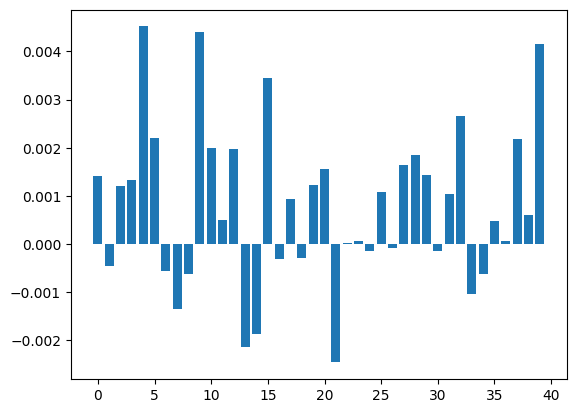

In [6]:
from scipy.stats import sem
v = np.array([sum(x)/len(x) for x in zip(*imp_score)])
print(np.array([np.std(x) for x in zip(*imp_score)]))
print(np.array([sem(x) for x in zip(*imp_score)]))
plt.bar([x for x in range(len(v))], v)

In [7]:
for i,z in enumerate(v):
 print('Feature: %0d, Score: %.5f' % (i,z))

Feature: 0, Score: 0.00141
Feature: 1, Score: -0.00045
Feature: 2, Score: 0.00120
Feature: 3, Score: 0.00133
Feature: 4, Score: 0.00452
Feature: 5, Score: 0.00221
Feature: 6, Score: -0.00056
Feature: 7, Score: -0.00136
Feature: 8, Score: -0.00063
Feature: 9, Score: 0.00440
Feature: 10, Score: 0.00200
Feature: 11, Score: 0.00050
Feature: 12, Score: 0.00197
Feature: 13, Score: -0.00213
Feature: 14, Score: -0.00187
Feature: 15, Score: 0.00345
Feature: 16, Score: -0.00031
Feature: 17, Score: 0.00093
Feature: 18, Score: -0.00030
Feature: 19, Score: 0.00123
Feature: 20, Score: 0.00156
Feature: 21, Score: -0.00246
Feature: 22, Score: 0.00002
Feature: 23, Score: 0.00007
Feature: 24, Score: -0.00015
Feature: 25, Score: 0.00109
Feature: 26, Score: -0.00009
Feature: 27, Score: 0.00164
Feature: 28, Score: 0.00184
Feature: 29, Score: 0.00143
Feature: 30, Score: -0.00015
Feature: 31, Score: 0.00103
Feature: 32, Score: 0.00266
Feature: 33, Score: -0.00103
Feature: 34, Score: -0.00063
Feature: 35, Sco

In [8]:
neg_class_prob_sorted = clf_balanced.feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = clf_balanced.feature_log_prob_[1, :].argsort()[::-1]

print(np.take(feature_top_40, neg_class_prob_sorted[:10]))
print(np.take(feature_top_40, pos_class_prob_sorted))
print(pos_class_prob_sorted)
clf_balanced.feature_log_prob_[1, :]

['VSA_EState3' 'Chi4n' 'SMR_VSA10' 'NumAromaticCarbocycles' 'VSA_EState10'
 'NumHeteroatoms' 'NumHAcceptors' 'TPSA' 'BalabanJ' 'fr_C_O']
['Kappa1' 'NumHeteroatoms' 'SlogP_VSA2' 'MinPartialCharge' 'Chi2v'
 'NumAromaticCarbocycles' 'FractionCSP3' 'NumHAcceptors' 'SMR_VSA3'
 'SlogP_VSA10' 'VSA_EState7' 'fr_Ar_N' 'TPSA' 'FpDensityMorgan3'
 'fr_phenol_noOrthoHbond' 'SMR_VSA1' 'EState_VSA1' 'BalabanJ'
 'VSA_EState10' 'VSA_EState9' 'VSA_EState3' 'Chi4n' 'MinAbsPartialCharge'
 'SMR_VSA5' 'SMR_VSA10' 'VSA_EState2' 'HallKierAlpha' 'VSA_EState6'
 'SlogP_VSA1' 'FpDensityMorgan2' 'fr_ether' 'fr_C_O' 'MaxAbsPartialCharge'
 'BCUT2D_LOGPLOW' 'PEOE_VSA1' 'fr_Al_OH_noTert' 'MaxPartialCharge'
 'BCUT2D_CHGLO' 'EState_VSA10' 'SlogP_VSA12']
[ 9  5 12 28 10  4 16  3 33 17 15 24  1 34 21  2 27 37  7 32  8  6 31 14
 11 19 13 29 22 20 26  0 38 18 23 36 30 25 39 35]


array([-0.97992632, -0.78386089, -0.80485117, -0.73747577, -0.66904963,
       -0.57807785, -0.8262915 , -0.81398365, -0.82011864, -0.5171691 ,
       -0.62000754, -0.89021102, -0.60252895, -0.90685034, -0.87384404,
       -0.76039941, -0.69586089, -0.75461904, -1.03942342, -0.90016135,
       -0.92377122, -0.79280283, -0.91358437, -1.09455549, -0.77499821,
       -1.3516704 , -0.94795201, -0.80788607, -0.60749174, -0.90685034,
       -1.33608567, -0.86094064, -0.81704644, -0.74601067, -0.78386089,
       -2.22191719, -1.17899381, -0.81093022, -0.99814176, -1.8590117 ])

In [9]:
pos_class_prob = np.array([sum(x)/len(x) for x in zip(*pos_class)]).argsort()[::-1]
print(np.take(feature_top_40, pos_class_prob))

[]


In [10]:
# pos_class.to_csv(path + 'pos_class')
np.save(path + 'imp_score.npy', imp_score)

In [ ]:
print(np.mean(bal_accs_t))
print(np.std(bal_accs_t))

0.6868922145868583
0.016906110422884413


In [ ]:
#Training with new 40 features
print('BACC', np.mean(bal_accs_t))
print(np.std(bal_accs_t))

print('auc', np.mean(auc_scores_t))
print(np.std(auc_scores_t))

print('f1', np.mean(f1_scores_t))
print(np.std(f1_scores_t))

print('recall', np.mean(recall_scores_t))
print(np.std(recall_scores_t))

print('precision', np.mean(precision_scores_t))
print(np.std(precision_scores_t))

BACC 0.6835241369953103
0.015938044687144597
auc 0.754404065107381
0.017678898681924095
f1 0.2873169443945361
0.10894328485398197
recall 0.6663363399183627
0.02595082709992412
precision 0.19385744415229078
0.10455752948918516


In [ ]:
# Old 40 features
print('BACC', np.mean(bal_accs_w))
print(np.std(bal_accs_w))

print('auc', np.mean(auc_scores_w))
print(np.std(auc_scores_w))

print('f1', np.mean(f1_scores))
print(np.std(f1_scores))

print('recall', np.mean(recall_scores))
print(np.std(recall_scores))

print('precision', np.mean(precision_scores))
print(np.std(precision_scores))

BACC 0.6807777324824442
0.02652918650123065
auc 0.7508451522359342
0.026549774973513966
f1 0.28566126545602394
0.1090859883893046
recall 0.6650491057321166
0.05455258914475373
precision 0.19241420033553783
0.10415333696560004


In [ ]:
#new 40 features
print('BACC', np.mean(bal_accs_w))
print(np.std(bal_accs_w))

print('auc', np.mean(auc_scores_w))
print(np.std(auc_scores_w))

print('f1', np.mean(f1_scores))
print(np.std(f1_scores))

print('recall', np.mean(recall_scores))
print(np.std(recall_scores))

print('precision', np.mean(precision_scores))
print(np.std(precision_scores))

BACC 0.6787071680204717
0.025111822940463022
auc 0.7476749769570099
0.025737784712471845
f1 0.28138139869505596
0.11095644338870612
recall 0.657219127565591
0.0483968408660744
precision 0.18980996879306947
0.10623245060251486


In [ ]:
pd.DataFrame(bal_accs_w).to_csv(path + 'nb_bal_acc_90_10.csv', index=False)
pd.DataFrame(auc_scores_w).to_csv(path + 'nb_auc_90_10.csv', index=False)
pd.DataFrame(bal_accs_t).to_csv(path + 'nb_bal_acc_t_90_10.csv', index=False)
pd.DataFrame(auc_scores_t).to_csv(path + 'nb_auc_t_90_10.csv', index=False)

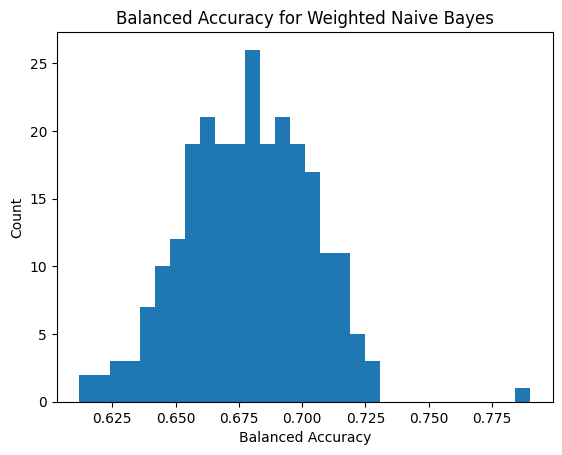

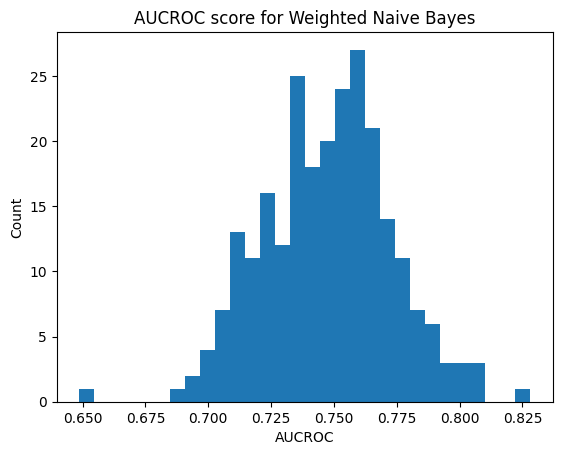

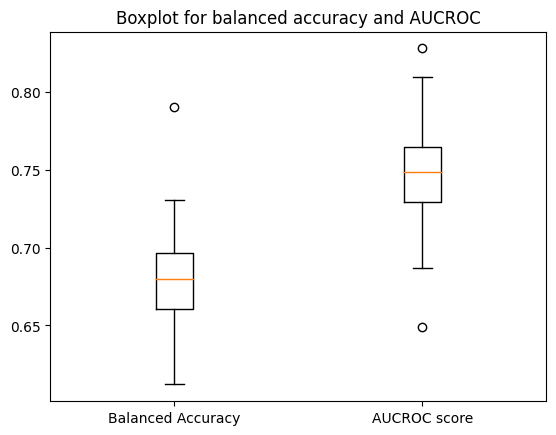

In [ ]:
plt.hist(bal_accs_w, bins = 30)
plt.title('Balanced Accuracy for Weighted Naive Bayes')
plt.xlabel('Balanced Accuracy')
plt.ylabel('Count')
plt.show()

plt.hist(auc_scores_w, bins = 30)
plt.title('AUCROC score for Weighted Naive Bayes')
plt.xlabel('AUCROC')
plt.ylabel('Count')
plt.show()


plt.boxplot([bal_accs_w, auc_scores_w])
plt.title('Boxplot for balanced accuracy and AUCROC')
plt.xticks([1, 2], ["Balanced Accuracy","AUCROC score"])
plt.show()

In [ ]:
print(balanced_accuracy_score(y_test,y_pred_balanced))
print(metrics.accuracy_score(y_test,y_pred_balanced))
print(classification_report(y_test,y_pred_balanced))
print(metrics.average_precision_score(y_test, y_pred_balanced))
print(metrics.roc_auc_score(y_test, y_pred_balanced))

0.7243763201183604
0.7047949162333911
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      1447
           1       0.33      0.75      0.46       284

    accuracy                           0.70      1731
   macro avg       0.63      0.72      0.63      1731
weighted avg       0.84      0.70      0.74      1731

0.2866276344436852
0.7243763201183605


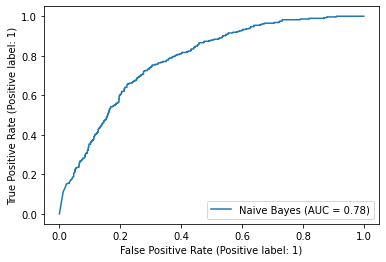

In [ ]:
ax = plt.gca()
RocCurveDisplay.from_estimator(clf_balanced, X_test, y_test,ax=ax,name="Naive Bayes")
plt.show()

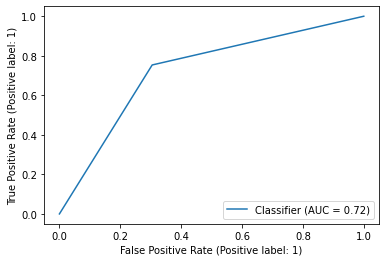

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred_balanced)

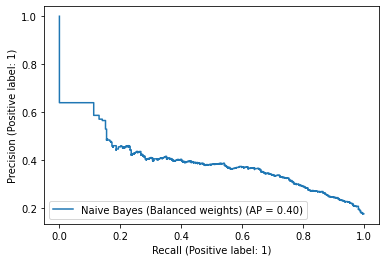

In [ ]:
ax = plt.gca()
PrecisionRecallDisplay.from_estimator(clf_balanced, X_test, y_test,ax=ax,name="Naive Bayes (Balanced weights)")


In [ ]:
print(np.mean(bal_accs))
print(np.mean(bal_accs_w))

0.677398287324876
0.6930723030380814


As a summary so far, compare with unbalanced naive bayesian model, the balanced accuracy increased about 2 percent, the average balanced accuracy is 69.31%. Tried log-transformed the features, however, many of them are giving nans and zeros, even after +1, so we stay with standard scaler.

## Pymc data with naive bayesian with priors

In [ ]:
df = pd.read_csv('pymc_data.csv')
df_1 = df.iloc[:100, :5]
df_1['outcome'] = df.iloc[:100, -6]
df_2 = df.iloc[100:200, :5]
df_2['outcome'] = df.iloc[100:200, -6]
df_3 = df.iloc[200:300, :5]
df_3['outcome'] = df.iloc[200:300, -6]
df_4 = df.iloc[300:, :5]
df_4['outcome'] = df.iloc[300:, -6]
df_list = [df_1, df_2, df_3, df_4]

In [ ]:
one_assay = df_list[3]
one_assay = one_assay.drop(one_assay.columns[0],axis=1)
# scaler = StandardScaler().fit(one_assay.iloc[:,:4])

# X = scaler.transform(one_assay.iloc[:,:4])
# y = label_encoder.fit_transform(one_assay.iloc[:,4])
one_assay.iloc[:,4].value_counts()

0.0    50
1.0    50
Name: outcome, dtype: int64

0
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       1.00      0.62      0.77         8

    accuracy                           0.85        20
   macro avg       0.90      0.81      0.83        20
weighted avg       0.88      0.85      0.84        20



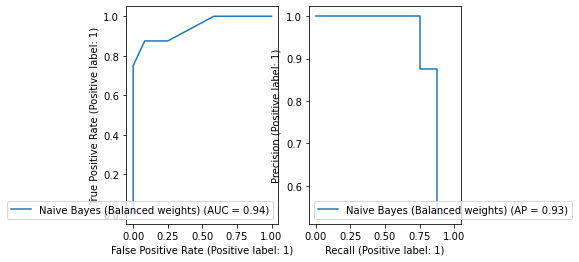

1
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.67      0.75      0.71         8

    accuracy                           0.75        20
   macro avg       0.74      0.75      0.74        20
weighted avg       0.76      0.75      0.75        20



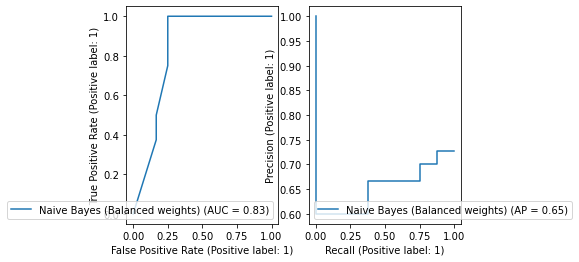

2
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.56      0.62      0.59         8

    accuracy                           0.65        20
   macro avg       0.64      0.65      0.64        20
weighted avg       0.66      0.65      0.65        20



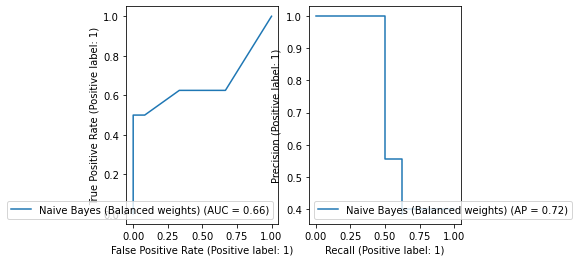

3
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.67      0.75      0.71         8

    accuracy                           0.75        20
   macro avg       0.74      0.75      0.74        20
weighted avg       0.76      0.75      0.75        20



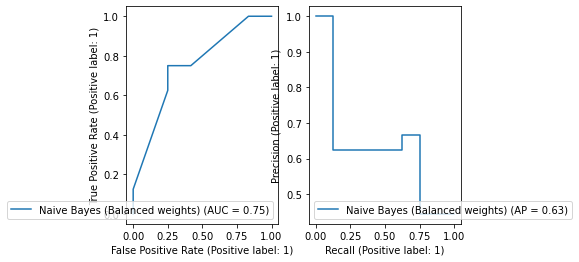

In [ ]:
label_encoder = preprocessing.LabelEncoder()

bal_accs_w = []
auc_scores_w = []
for i in range(len(df_list)):
    one_assay = df_list[i]
    one_assay = one_assay.drop(one_assay.columns[0],axis=1)
    scaler = StandardScaler().fit(one_assay.iloc[:,:4])

    X = scaler.transform(one_assay.iloc[:,:4])
    y = label_encoder.fit_transform(one_assay.iloc[:,4])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state = 42)

    class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train
                                    )
    class_weights = dict(zip(np.unique(y_train), class_weights))

    class_wt = []
    for j in y_train:
        if j == 0:
            class_wt.append(class_weights[0])
        elif j == 1:
            class_wt.append(class_weights[1])

    clf_balanced = BernoulliNB(alpha = 50).fit(X_train, y_train, sample_weight = class_wt)

    y_pred_balanced = clf_balanced.predict(X_test)
    y_pred_prob = clf_balanced.predict_proba(X_test)
    print(i)
    print(classification_report(y_test,y_pred_balanced))

    bal_acc = balanced_accuracy_score(y_test,y_pred_balanced)
    bal_accs_w.append(bal_acc)

    auc = metrics.roc_auc_score(y_test, y_pred_prob[:, 1])
    auc_scores_w.append(auc)

    fig, (ax, ax1) = plt.subplots(1,2)
#     ax = plt.gca()

    RocCurveDisplay.from_estimator(clf_balanced, X_test, y_test,ax=ax,name="Naive Bayes (Balanced weights)")

#     ax1 = plt.gca()

    PrecisionRecallDisplay.from_estimator(clf_balanced, X_test, y_test,ax=ax1,name="Naive Bayes (Balanced weights)")

    plt.show()

In [ ]:
print(np.mean(bal_accs_w))
print(np.mean(auc_scores_w))

0.7395833333333333
0.796875
